In [39]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering,MiniBatchKMeans,KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import hdbscan
from hdbscan import HDBSCAN


from matplotlib.pyplot import figure

import pytraj as pt
import nglview as nv

In [40]:
def create_dir(parent_directory, directory):
    # Concatenate parent directory and directory name
    full_path = os.path.join(parent_directory, directory)
    
    if not os.path.exists(full_path):
        os.makedirs(full_path)
        print(f"Directory '{directory}' created successfully inside '{parent_directory}'.")
    else:
        print(f"Directory '{directory}' already exists inside '{parent_directory}'.")

In [41]:
def select_colvar_bylowest_rbias(colvar_df,system,dvalues,nframes):
    "select nframes of colvar in d1.z and d2.z range with lowest rbias"
    colvar_dz=colvar_df.loc[(colvar_df['system']==system) & (colvar_df['d2.z'] <= dvalues[0]) & 
                    (colvar_df['d2.z'] >= dvalues[1]) & (colvar_df['d1.z'] <= dvalues[2]) &
                    (colvar_df['d1.z'] >= dvalues[3])]

    colvar_lowest_rbias=colvar_dz.sort_values(by=['rbias'])[:nframes]
    return colvar_lowest_rbias

In [42]:
def select_colvar_bylargest_rbias(colvar_df,system,dvalues,nframes):
    "select nframes of colvar in d1.z and d2.z range with lowest rbias"
    colvar_dz=colvar_df.loc[(colvar_df['system']==system) & (colvar_df['d2.z'] <= dvalues[0]) & 
                    (colvar_df['d2.z'] >= dvalues[1]) & (colvar_df['d1.z'] <= dvalues[2]) &
                    (colvar_df['d1.z'] >= dvalues[3])]

    colvar_largest_rbias=colvar_dz.sort_values(by=['rbias'], ascending=False)[:nframes]
    return colvar_largest_rbias

In [43]:
def select_colvar_nosorting(colvar_df,system,dvalues,nframes,random_seed):
    "select nframes of colvar in d1.z and d2.z range with lowest rbias"
    colvar_dz=colvar_df.loc[(colvar_df['system']==system) & (colvar_df['d2.z'] <= dvalues[0]) & 
                    (colvar_df['d2.z'] >= dvalues[1]) & (colvar_df['d1.z'] <= dvalues[2]) &
                    (colvar_df['d1.z'] >= dvalues[3])]
    #selecting random frames with .sample()
    colvar_nosorting=colvar_dz.sample(nframes,random_state=random_seed)
    return colvar_nosorting

In [44]:
def select_alldata_bytime(colvar_sel,alldata_df,sys):

    sel_rbias=[]
    selframes=[]
    for ind,row in colvar_sel.iterrows():
        #print(row)
        selframes.append(alldata_df.loc[(alldata_df['system']==row['system']) & (alldata_df['chain']==row['chain'])
        & (alldata_df['walker']==row['walker']) & (alldata_df['time (ps)']==row['time (ps)'])].index.to_list())

        sel_rbias.append(row['rbias'])
    sel_frames=[frame for sublist in selframes for frame in sublist]
        
    return(sel_frames, sel_rbias)

In [76]:
def write_pdb(alldata_df, sel_frames, sel_frames_rbias, trajspath,align_mask, min_name, outdir):
    for n,fr in enumerate(sel_frames):
        system=alldata_df['system'].iloc[fr:fr+1].to_string(index=False)
        walker=alldata_df['walker'].iloc[fr:fr+1].to_string(index=False)
        chain=alldata_df['chain'].iloc[fr:fr+1].to_string(index=False)
        traj_frame_from0=int(float(alldata['time'].iloc[fr:fr+1].to_string(index=False)))
        topname='{trajspath}/{system}_mon.pdb'.format(trajspath=trajspath,system=system)
        trajname='{trajspath}/trajs_mon_wat/phase2/{system}_mw{walker}_ch{chain}.xtc'.format(trajspath=trajspath, 
                                                                        system=system, walker=walker,
                                                                        chain=chain)
        print('extracting frame with rbias '+str(sel_frames_rbias[n]))
        current_structure=pt.load(trajname,top=topname,frame_indices=[traj_frame_from0])
        if (n == 0):
            ref=current_structure.copy()
            aligned_structure=ref.copy()
        elif (n != 0):
            aligned_structure=pt.align(current_structure,ref=ref,mask=align_mask, ref_mask=align_mask)
        outpdb='{outdir}/{min_name}/rbias{rbias}_frame{fr}.pdb'.format(outdir=outdir,min_name=min_name,rbias=sel_frames_rbias[n],fr=fr)
        pt.write_trajectory(outpdb,aligned_structure,format='pdb',overwrite=True)


In [77]:
def write_pdb_dimer(alldata_df, sel_frames, sel_frames_rbias, trajspath, strip_mask, align_mask, min_name, outdir):
    for n,fr in enumerate(sel_frames):
        system=alldata_df['system'].iloc[fr:fr+1].to_string(index=False)
        walker=alldata_df['walker'].iloc[fr:fr+1].to_string(index=False)
        traj_frame_from0=int(float(alldata['time'].iloc[fr:fr+1].to_string(index=False)))
        topname='{trajspath}/{system}/trajs_phase2/all.pdb'.format(trajspath=trajspath,system=system)
        trajname='{trajspath}/{system}/trajs_phase2/mw{walker}_all_image.xtc'.format(trajspath=trajspath, 
                                                                        system=system, walker=walker)
        #print('topname =',topname)
        #print('trajname =',trajname)
                                                                    
        print('extracting frame with rbias '+str(sel_frames_rbias[n]))
        current_structure=pt.load(trajname,top=topname,frame_indices=[traj_frame_from0])
        if (n == 0):
            ref=current_structure.copy()
            aligned_structure=ref.copy()
        elif (n != 0):
            aligned_structure=pt.align(current_structure,ref=ref,mask=align_mask, ref_mask=align_mask)
        stripped_traj=pt.strip(aligned_structure,strip_mask)
        outpdb='{outdir}/{min_name}/rbias{rbias}_frame{fr}.pdb'.format(outdir=outdir,min_name=min_name,rbias=sel_frames_rbias[n],fr=fr)
        pt.write_trajectory(outpdb,stripped_traj,format='pdb',overwrite=True)


In [60]:
trajspath='/orozco/projects/E-Dent/VERONICA/DIMER_LARGER/mw_metad'
titles=['wild Gext0','wild Gext-','mut Gext0', 'wild Gext-']
titles2=['WP','WD','MP', 'MD']
names=['wt_Glu0','wt_Glu-','mut_Glu0', 'mut_Glu-']
walkers=np.arange(0,8)
chains=['A','B']

## Loading COLVAR data

In [65]:
data=[]
path='/orozco/projects/E-Dent/MILOSZ/meta/phase2/colvars'
plumed_files=[]
for index,name in enumerate(titles2):
    data.append([])
    for chain in chains:
        for walker in walkers:
            ftemp='{path}/{name}/{w}/COLVAR'.format(path=path,name=name,w=walker)
            if (chain=='A'):
              dtemp=pd.read_csv(ftemp,delimiter=" ",comment='#',skipinitialspace=True,usecols=[0,3,8,25],names=['time','d1.z','d2.z','rbias'])  
            elif (chain=='B'):
              dtemp=pd.read_csv(ftemp,delimiter=" ",comment='#',skipinitialspace=True, usecols=[0,13,18,29],names=['time','d1.z','d2.z','rbias'])
            dtemp['chain']=chain
            dtemp['name']=name
            dtemp['walker']=walker  
            dtemp['time (ps)']=np.round(dtemp['time']).astype(int)
            if (name=='WP'):
                dtemp['system']='wt_Glu0'
            if (name=='WD'):
                dtemp['system']='wt_Glu-'
            if (name=='MP'):
                dtemp['system']='mut_Glu0'
            if (name=='MD'):
                dtemp['system']='mut_Glu-'
            data[index].append(dtemp)
            #plumed_files.append(temp)
colvar_sys=[]
#for each system sys I concatenate the walkers n, poi li appendo. L'ordine è quello di names
for sys,name in enumerate(titles):
    tmp=pd.concat(data[sys][n] for n,m in enumerate(data[sys]))
    colvar_sys.append(tmp)
    
#ora concateno i 4 sistemi    
colvar_allconc=pd.concat((colvar_sys[n] for n,m in enumerate(colvar_sys)),ignore_index=True)
len(colvar_allconc)

1990870

In [48]:
colvar_allconc[0:100:25]['time (ps)'].values.tolist()

[0, 500, 1000, 1500]

# Loading dz data

In [66]:
dz_allconc=[]
data=[]
for index,name in enumerate(names):
    data.append([])
    for chain in chains:
        for walker in walkers:
            ftemp='/orozco/projects/E-Dent/VERONICA/DIMER_LARGER/mw_metad/analysis_phase2/dz/{system}/{system}.mw{w}.{ch}.analysis.dat'.format(system=name,w=walker,ch=chain)
            dtemp=pd.read_csv(ftemp,delimiter=" ",skipinitialspace=True,usecols=[0,1,2],names=['time','d1.z','d2.z'],skiprows=1)
            dtemp['ctrl']=name
            if (name=='wt_Glu0'):
                dtemp['charge']='0'
            if (name=='wt_Glu-'):
                dtemp['charge']='-1'
            if (name=='mut_Glu0'):
                dtemp['charge']='0'
            if (name=='mut_Glu-'):
                dtemp['charge']='-1'
            dtemp['chain']=chain
            dtemp['system']=name
            dtemp['walker']=walker
            dtemp['time (ps)']=(dtemp['time']*500).astype(int)
            data[index].append(dtemp)
data[0][8].head(2)

data_sys=[]
for sys,name in enumerate(names):
    tmp=pd.concat(data[sys][n] for n,m in enumerate(data[sys]))
    data_sys.append(tmp)
    
dz_allconc=pd.concat((data_sys[n] for n,m in enumerate(data_sys)),ignore_index=True)
#dz_allconc.head()

In [50]:
#dz_allconc.loc[(dz_allconc['time(ps)']==500.0)]

# Add to alldata

In [67]:
alldata=dz_allconc.copy()
alldata.head()

,time,d1.z,d2.z,ctrl,charge,chain,system,walker,time (ps)
0,0.0,1.722141,12.372143,wt_Glu0,0,A,wt_Glu0,0,0
1,1.0,-2.002858,12.027140,wt_Glu0,0,A,wt_Glu0,0,500
2,2.0,-4.301784,11.988217,wt_Glu0,0,A,wt_Glu0,0,1000
3,3.0,-4.937858,10.472145,wt_Glu0,0,A,wt_Glu0,0,1500
4,4.0,-4.530357,10.499642,wt_Glu0,0,A,wt_Glu0,0,2000


# Extract minima from WD at y=5, x=-2.5; y=0 or 2, x=6  (they exist only for WD fes2 and only a combination of d2.z and d1.z).

In [87]:
### change here ####
m='M4w'
nframes=10
align_mask=':1-510@CA,C,N,O'
####################

min_name=m
sys='wt_Glu-'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"

#M4w not going down (hb between glu ext and glu in)
dvalues5y=[4.62, 3.6, -1.4, -3.6]
#M4w  with other CLA (it goes down alone)
dvalues5yn=[-1.4,-3.6,4.6,2]
dvalues5yn_down=[-3.7,-5.7,6,2]
dvalues5yn_moredown=[-5.8,-8,6,2]
#tra M3w e M4w
dvalues02y=[3.1,-1.6,6.8,5]

#others
dvalues2=[2.9,1.8,11,10.25]
dvalues0=[0.7,-0.5,11,10.25]


if (m=='M4w'):
    dvalues=dvalues5y.copy()
elif (m=='M4w_2'):
    dvalues=dvalues5yn.copy()
elif (m=='M4w_2_down'):
    dvalues=dvalues5yn_down.copy()
elif (m=='M4w_2_moredown'):
    dvalues=dvalues5yn_moredown.copy()
elif (m=='Mint'):
    dvalues=dvalues02y.copy()
#others
elif (m=='min0_wd'):
    dvalues=dvalues0.copy()
elif (m=='min2_wd'):
    dvalues=dvalues2.copy()



#sel lowest rbias from colvar
colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues,nframes)
#it will create a dir M4w inside frames_extracted_largest_bias if it does not exist already
#create_dir(outdir, min_name)
#sel frames with lowest rbias from alldata
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)
#write pdb for each frame with lowest rbias 
#write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath,align_mask, min_name, outdir)
print(colvar_largest_rbias)

                  time      d1.z      d2.z      rbias chain name  walker  \
1112657  650500.030897 -3.082372  3.994250  -6.190878     B   WD       7   
1112707  651500.030945 -2.802861  3.769091  -7.071622     B   WD       7   
1114207  681500.032370 -1.515663  3.903977  -7.484714     B   WD       7   
1114032  678000.032203 -1.772394  4.176238  -7.719164     B   WD       7   
1114232  682000.032393 -2.193029  3.604479  -7.771607     B   WD       7   
1113057  658500.031277 -2.626322  3.628813  -8.378238     B   WD       7   
1112032  638000.030303 -3.217084  3.789042  -8.818381     B   WD       7   
1112332  644000.030588 -3.134498  4.527070  -9.528538     B   WD       7   
1111882  635000.030161 -2.642416  4.002420 -10.244746     B   WD       7   
1113107  659500.031325 -1.822492  4.066279 -11.152467     B   WD       7   

         time (ps)   system  
1112657     650500  wt_Glu-  
1112707     651500  wt_Glu-  
1114207     681500  wt_Glu-  
1114032     678000  wt_Glu-  
1114232     6

## equivalent M4m to M4w minimum

In [52]:
### change here ####
m='M4m_2'
nframes=10
align_mask=':1-510@CA,C,N,O'
####################

min_name=m
sys='mut_Glu-'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"

#M4w not going down (hb between glu ext and glu in)
dvalues5y=[4.62, 3.6, -1.4, -3.6]
#M4w  with other CLA (it goes down alone)
dvalues5yn=[-1.4,-3.6,4.6,2]



if (m=='M4m'):
    dvalues=dvalues5y.copy()
elif (m=='M4m_2'):
    dvalues=dvalues5yn.copy()



#sel lowest rbias from colvar
colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues,nframes)
#it will create a dir M4w inside frames_extracted_largest_bias if it does not exist already
create_dir(outdir, min_name)
#sel frames with lowest rbias from alldata
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)
#write pdb for each frame with lowest rbias 
#write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath,align_mask, min_name, outdir)
print(colvar_largest_rbias)

Directory 'M4m_2' already exists inside 'frames_extracted_largest_rbias'.
                  time      d1.z      d2.z      rbias chain name  walker  \
1839736   84500.004014  2.544610 -3.273734 -19.484529     B   MD       3   
1837051   31000.001472  3.412094 -3.459358 -21.298327     B   MD       3   
1536017  133000.006317  3.619897 -3.258811 -22.489964     A   MD       1   
1841486  119500.005676  2.980068 -1.472622 -23.005621     B   MD       3   
1837026   30500.001449  3.961357 -3.458412 -23.813480     B   MD       3   
1841286  115500.005486  2.907992 -2.628851 -23.879859     B   MD       3   
1836376   17500.000831  3.813595 -2.958035 -27.044648     B   MD       3   
1839661   83000.003942  2.064212 -3.014767 -27.839102     B   MD       3   
1839536   80500.003824  2.134202 -3.291976 -28.104153     B   MD       3   
1536067  134000.006365  3.104287 -2.884208 -28.290924     A   MD       1   

         time (ps)    system  
1839736      84500  mut_Glu-  
1837051      31000  mut_Glu

In [224]:
m='min1_MUT'
nframes=2
mask=':1-510@CA,C,N,O'

min_name=m
sys='mut_Glu0'

alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"

dvalues1M=[3.5,-1,12,10.5]



#sel lowest rbias from colvar
colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues,nframes)
#sel frames with lowest rbias from alldata
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)
#write pdb for each frame with lowest rbias 
write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath,mask, min_name, outdir)

## Write wt_Glu0 minima frames with largest reduced bias factor


In [84]:
### change here ####
m='M1w_2'
nframes=10
align_mask=':1-510@CA,C,N,O'
####################

min_name=m
sys='wt_Glu0'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"
outdir2='frames_largest_bias_forCarles'
stripmask='(:TIP3,TIP,WAT,CLA,SOD)'

dvalues0=[11, 9.7, 0.8, -0.8]
dvalues0_2=[0.8, -0.8, 11, 9.7]

dvalues2=[11, 8.7, 3.8, 1.2]
dvalues2_2=[3.8, 1.2, 8,7, 11]

dvalues5=[11, 9.7, 5.95, 4.75]
dvalues5_2=[5.95, 4.75, 11, 9.7]

if (m=='M1w'):
    dvalues=dvalues5.copy()
elif (m=='M1w_2'):
    dvalues=dvalues5_2.copy()

elif (m=='M2w'):
    dvalues=dvalues2.copy()
elif (m=='M2w_2'):
    dvalues=dvalues2_2.copy()

elif (m=='M3w'):
    dvalues=dvalues0.copy()
elif (m=='M3w_2'):
    dvalues=dvalues0_2.copy()

#sel lowest rbias from colvar
colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues,nframes)
#sel frames with lowest rbias from alldata
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)
print(colvar_largest_rbias)
create_dir(outdir2, min_name)
#write pdb for each frame with lowest rbias 
#write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath, align_mask, min_name, outdir)
write_pdb_dimer(alldata, sel_frames, sel_frames_rbias, trajspath, stripmask, align_mask, min_name, outdir2)

                 time       d1.z      d2.z     rbias chain name  walker  \
105123  545000.025886  10.737494  5.623648  3.345953     A   WP       2   
105023  543000.025791  10.820210  5.664181  3.098927     A   WP       2   
104773  538000.025554  10.976737  5.627028  3.017116     A   WP       2   
105423  551000.026171  10.799484  5.334564  2.643559     A   WP       2   
104898  540500.025672  10.814225  5.649003  2.526945     A   WP       2   
104948  541500.025720  10.702037  5.664516  2.336442     A   WP       2   
105223  547000.025981  10.415800  5.654875  2.029794     A   WP       2   
104748  537500.025530  10.957865  5.303843  2.000665     A   WP       2   
105448  551500.026195  10.411269  5.477470  1.638251     A   WP       2   
105048  543500.025815  10.616821  5.393692  1.474950     A   WP       2   

        time (ps)   system  
105123     545000  wt_Glu0  
105023     543000  wt_Glu0  
104773     538000  wt_Glu0  
105423     551000  wt_Glu0  
104898     540500  wt_Glu0  


In [245]:
### change here ####
m='exit_W-_m5m7'
nframes=10
mask=':1-510@CA,C,N,O'
####################

min_name=m
sys='wt_Glu-'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"

dvalues_m5m7=[-2,-5,-3 ,-7]
dvalues_m5m10=[-5,-10,-5,-10]

if (m=='exit_W-_m5m7'):
    dvalues=dvalues_m5m7.copy()
elif (m=='exit_W-_m5m10'):
    dvalues=dvalues_m5m10.copy()



#sel lowest rbias from colvar
colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues,nframes)
print(colvar_lowest_rbias)
#sel frames with lowest rbias from alldata
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)
print(sel_frames_rbias)

#write pdb for each frame with lowest rbias 
write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath, mask, min_name, outdir)

                 time      d1.z      d2.z      rbias chain name  walker  \
718719  619500.029425 -9.248136 -9.663504 -61.253787     A   WD       3   
718619  617500.029330 -8.728839 -9.582221 -59.837940     A   WD       3   
716569  576500.027382 -5.446368 -6.592822 -58.859090     A   WD       3   
717419  593500.028190 -6.497283 -9.486415 -58.427453     A   WD       3   
716494  575000.027311 -5.503304 -6.943425 -58.148043     A   WD       3   
716519  575500.027335 -5.133639 -7.184943 -56.957257     A   WD       3   
714941  544000.025839 -9.675135 -5.810084 -56.551633     A   WD       3   
716594  577000.027406 -5.201679 -7.023727 -56.365064     A   WD       3   
716644  578000.027454 -6.124257 -7.671663 -56.153813     A   WD       3   
714916  543500.025815 -8.873848 -5.767170 -55.955107     A   WD       3   

        time (ps)   system  
718719     619500  wt_Glu-  
718619     617500  wt_Glu-  
716569     576500  wt_Glu-  
717419     593500  wt_Glu-  
716494     575000  wt_Glu-  


### write wt_Glu- minima frames with largest reduced bias factor

## exit from WD

In [38]:
### change here ###
m='exit1'
nframes=5
align_mask=':1-510@CA,C,N,O'
###################

min_name=m
sys='wt_Glu-'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"

dvalues1=[-3.5,-12,-3.5,-12]
dvalues3=[-5,-8,-5,-8]

dvalues4=[-6,-8,-1,-4]
dvalues5=[-3,-8,0.8,-0.6]
dvalues6=[0,-2.5,-5,-9]
dvalues7=[-8,-12,-12,-14]
dvalues8=[-2,-14,3.5,1.5]
dvalues9=[-9,-14,-4,-9]

dvalues10=[-5,-7,-5,-7]
dvalues11=[-9,-11,-9,-11]




colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues1,nframes)
    
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)

#it will create a dir M4w inside frames_extracted_largest_bias if it does not exist already
#create_dir(outdir, min_name)

#print(sel_frames, sel_frames_rbias)
print(colvar_largest_rbias[50:])

#write pdb for each frame with lowest rbias 
#write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath, align_mask, min_name, outdir)

Empty DataFrame
Columns: [time, d1.z, d2.z, rbias, chain, name, walker, time (ps), system]
Index: []


## MD minimum

In [80]:
### change here ###
m='M3m_2'
nframes=10
align_mask=':1-510@CA,C,N,O'
###################

min_name=m
sys='mut_Glu-'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"

dvalues1=[11,5,0,-11]
dvalues2=[0,-11,11,5]

outdir2='frames_largest_bias_forCarles'
stripmask='(:TIP3,TIP,WAT,CLA,SOD)'


colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues2,nframes)
    
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)

#it will create a dir M4w inside frames_extracted_largest_bias if it does not exist already
#create_dir(outdir, min_name)
create_dir(outdir2, min_name)

#print(sel_frames, sel_frames_rbias)
print(colvar_largest_rbias)

#write pdb for each frame with lowest rbias 
#write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath, align_mask, min_name, outdir)
write_pdb_dimer(alldata, sel_frames, sel_frames_rbias, trajspath, stripmask, align_mask, min_name, outdir2)

Directory 'M3m_2' already exists inside 'frames_largest_bias_forCarles'.
                  time       d1.z       d2.z     rbias chain name  walker  \
1750045   82500.003919  10.770548  -2.850851  5.744488     B   MD       0   
1750170   85000.004037  10.782437  -3.104038  5.022732     B   MD       0   
1755196  185500.008811  10.988649  -3.733915  4.804796     B   MD       0   
1749945   80500.003824  10.912620  -2.895173  4.504339     B   MD       0   
1567685  178500.008478  10.242016 -10.466152  4.345299     A   MD       2   
1584918  522000.024794   9.861270  -6.483617  3.949408     A   MD       2   
1567785  180500.008573  10.330066 -10.229169  3.834612     A   MD       2   
1755021  182000.008645  10.923590  -3.820238  3.567318     B   MD       0   
1752996  141500.006721  10.510524  -3.051121  3.529229     B   MD       0   
1567485  174500.008288  10.495742 -10.896562  3.404805     A   MD       2   

         time (ps)    system  
1750045      82500  mut_Glu-  
1750170      8500

In [54]:
### change here ###
m='M5w_1'
nframes=10
align_mask=':1-510@CA,C,N,O'
###################

min_name=m
sys='wt_Glu-'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"

dvalues1=[11,5,0,-11]
dvalues2=[0,-11,11,5]




colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues1,nframes)
    
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)

#it will create a dir M4w inside frames_extracted_largest_bias if it does not exist already
create_dir(outdir, min_name)

#print(sel_frames, sel_frames_rbias)
print(colvar_largest_rbias)

#write pdb for each frame with lowest rbias 
#write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath, align_mask, min_name, outdir)

Directory 'M5w_1' already exists inside 'frames_extracted_largest_rbias'.
                time      d1.z       d2.z     rbias chain name  walker  \
787967   3000.000142 -0.737826  10.453604  3.711800     A   WD       6   
598423  14500.000689 -4.470359  10.997437  3.288491     A   WD       0   
602500  95500.004536 -6.139545  10.330060  2.473545     A   WD       0   
822491  14500.000689 -7.735504  10.112660  2.073643     A   WD       7   
602475  95000.004512 -6.075301  10.341836  2.009610     A   WD       0   
602662  98500.004678 -5.821956   9.959363  1.987981     A   WD       0   
822041   5500.000261 -8.314489  10.564554  1.875216     A   WD       7   
631853  36500.001734 -5.937881  10.769288  1.830606     A   WD       1   
602612  97500.004631 -5.383320  10.322681  1.803659     A   WD       0   
633392  67000.003182 -8.242040  10.076869  1.603100     A   WD       1   

        time (ps)   system  
787967       3000  wt_Glu-  
598423      14500  wt_Glu-  
602500      95500  wt_Gl

## exit without sorting by rbias

In [12]:


### change here ###
m='exit1'
nframes=1
align_mask=':1-510@CA,C,N,O'
###################

min_name=m
sys='wt_Glu-'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_nosorting"

dvalues1=[-3.5,-12,-3.5,-12]
dvalues2=[-8,-12,-8,-12]
dvalues3=[-5,-8,-5,-8]

dvalues4=[-6,-8,-1,-4]
dvalues5=[-3,-8,0.8,-0.6]
dvalues6=[0,-2.5,-5,-9]
dvalues7=[-8,-12,-12,-14]
dvalues8=[-2,-14,3.5,1.5]
dvalues9=[-9,-14,-4,-9]

dvalues10=[-5,-7,-5,-7]
dvalues11=[-9,-11,-9,-11]
dvalues12=[-7,-9,-7,-9]



random_seed=20
colvar_nosorting=select_colvar_nosorting(colvar,sys,dvalues11,nframes,random_seed)
    
#sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_nosorting,alldata,sys)

#it will create a dir M4w inside frames_extracted_largest_bias if it does not exist already
#create_dir(outdir, min_name)

#print(sel_frames, sel_frames_rbias)
#write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath, align_mask, min_name, outdir)
print(colvar_nosorting)


                 time       d1.z      d2.z      rbias chain name  walker  \
953211  144500.006863 -10.007515 -9.210457 -33.670557     B   WD       3   

        time (ps)   system  
953211     144500  wt_Glu-  


### write mut_Glu0 minima frames with smallest reduced bias factor

In [83]:
### change here ###
m='M2m_2'
nframes=10
mask=':1-510@CA,C,N,O'
###################

min_name=m
sys='mut_Glu0'
alldata=dz_allconc.copy()
colvar=colvar_allconc.loc[colvar_allconc['time (ps)']%500==0]
outdir="frames_extracted_largest_rbias"

outdir2='frames_largest_bias_forCarles'
stripmask='(:TIP3,TIP,WAT,CLA,SOD)'

dvalues1=[2.4,-1.5,11.5,8]
dvalues1_2=[11.5,8,2.4,-1.5]
dvalues2=[5,0,0,-5]
dvalues2_2=[0,-5,5,0]
if (m=='M1m'):
    dvalues=dvalues1.copy()
elif (m=='M1m_2'):
    dvalues=dvalues1_2.copy()
elif (m=='M2m'):
    dvalues=dvalues2.copy()
elif (m=='M2m_2'):
    dvalues=dvalues2_2.copy()




#sel lowest rbias from colvar
colvar_largest_rbias=select_colvar_bylargest_rbias(colvar,sys,dvalues,nframes)
#create_dir(outdir, min_name)
create_dir(outdir2, min_name)
#sel frames with lowest rbias from alldata
sel_frames, sel_frames_rbias=select_alldata_bytime(colvar_largest_rbias,alldata,sys)
print(colvar_largest_rbias)
#write pdb for each frame with lowest rbias 
#write_pdb(alldata, sel_frames, sel_frames_rbias, trajspath, align_mask, min_name, outdir)
#write_pdb_dimer(alldata, sel_frames, sel_frames_rbias, trajspath, stripmask, align_mask, min_name, outdir2)

Directory 'M2m_2' already exists inside 'frames_largest_bias_forCarles'.
                 time      d1.z      d2.z     rbias chain name  walker  \
1357965  14500.000689  0.140947 -4.543684  6.464463     B   MP       2   
1357915  13500.000641  0.138182 -4.127290  5.675237     B   MP       2   
1358015  15500.000736  0.677883 -4.353382  3.871285     B   MP       2   
1357440   4000.000190  0.526323 -4.899794  1.736335     B   MP       2   
1357940  14000.000665  0.073368 -3.452869  1.621882     B   MP       2   
1380709   7000.000332  1.949553 -4.882051  0.105211     B   MP       3   
1357815  11500.000546  0.587010 -3.653819 -0.688676     B   MP       2   
1358040  16000.000760  0.119403 -3.054288 -0.698152     B   MP       2   
1380684   6500.000309  2.279357 -4.957482 -2.578720     B   MP       3   
1357690   9000.000427  0.618397 -4.046101 -4.526710     B   MP       2   

         time (ps)    system  
1357965      14500  mut_Glu0  
1357915      13500  mut_Glu0  
1358015      15500 

In [102]:
print(np.sort(colvar_rbias.flatten())[:10])

[-79.910173 -79.582579 -79.311085 -78.605202 -78.504855 -78.433178
 -77.516054 -76.286632 -75.883394 -75.481478]


In [103]:
lowestrbias=(np.sort(colvar_rbias.flatten())[:10])

# Analysis

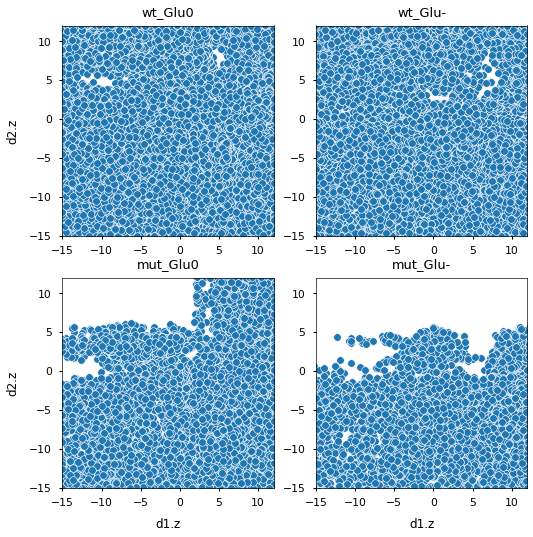

In [173]:
systems=['wt_Glu0','wt_Glu-','mut_Glu0','mut_Glu-']
f, axes=plt.subplots(2,2,figsize=(10,10))
for ind,ax in enumerate(axes.flat):
    tmpA=alldata.loc[(alldata['system']==systems[ind])]
    sb.scatterplot(x=tmpA['d1.z'],y=tmpA['d2.z'],ax=ax)
    #ax.set_ylim(7,22)
    if ((ind==0) or (ind==2)):
        ax.set_ylabel('d2.z')
    else:
        ax.set_ylabel('')
        
    if (ind>1):
        ax.set_xlabel('d1.z')
    else:
        ax.set_xlabel('')
    ax.set_ylim(-15,12)
    ax.set_xlim(-15,12)
    ax.set_title(systems[ind])
